##
For samling generation methods, such as Metropolis-Hastings, Gibbs, etc. 
A prior knowledge of the distribution is usually required.


Problem arises:

1. in Metropolis-Hastings, the step size can be limited by the distribution if the distribution has a variance that is not aligned with the coordinate axis.

2. in Gibbs, a double gaussian distribution can be difficult to sample from if the two gaussian are not aligned with the coordinate axis. The MC will end up trapped within one of the gaussian.


Both problem should be solved by using a transformation of the coordinate system, however, without knowing the distribution, what is the best way to transform the coordinate system?

1. Should we use PCA to transform the coordinate system to the direction of the highest variance?

2. What about non-linear transformation? How much of physical knowledge is required to perform such transformation?


Investigate the possible ways to the reparameterization
Investigate how much the reparameterisation can help with the convergence 
Investigate the effect in N-D and 2-D data 
- find a common group of multi-dimensional data to investigate 
Investigate if the best method is to reparameterise the axis or the steps

2D case

In [119]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [120]:
#create a function that defines the 2d rotational matrix
def rot2d(theta):
    return np.array([[math.cos(theta), -math.sin(theta)],[math.sin(theta), math.cos(theta)]])

In [121]:
# apply the rotation matrix to the vector
v = np.array([3, 1])
theta = math.pi/3
v_rot = np.dot(rot2d(theta), v)
print (v_rot)

[0.6339746  3.09807621]


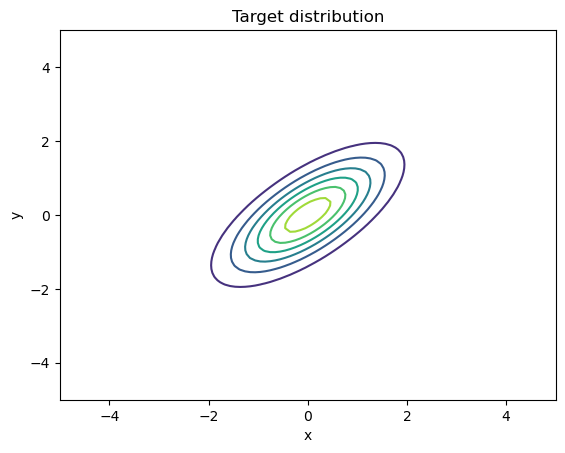

In [122]:
# define a 2D probabilitiy distribution
def target_logPDF(x, y, beta=0.7):
    return -0.5*(x**2+y**2-2*beta*x*y)/(1-beta**2)

# # define a 2D probabilitiy distribution that is the sum of two 2D gaussians
# def target_logPDF(x, y):
#     return  -0.5*(x**2+y**2) - 0.5*((x-5)**2+(y-5)**2)

#plot a density plot of the target distribution
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = target_logPDF(X, Y)
plt.contour(X, Y, np.exp(Z))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Target distribution')
plt.show()

In [123]:
# calculate the variance of the target distribution along the x and y axes
def variance(func):
    # integrate the function
    x = np.linspace(-10, 10, 1000)
    y = np.linspace(-10, 10, 1000)
    X, Y = np.meshgrid(x, y)
    Z = func(X, Y)
    Z = np.exp(Z)
    Z /= np.sum(Z)
    # calculate the variance
    x_mean = np.sum(x*Z)
    y_mean = np.sum(y*Z)
    var_x = np.sum((x-x_mean)**2*Z)
    var_y = np.sum((y-y_mean)**2*Z)
    return var_x, var_y

print (variance(target_logPDF))


(0.999999999999999, 0.999999999999999)


In [124]:
# Calculate the variance across the rotation space
def variance_rotation(func):
    # rotate the distribution
    var = []
    for theta in np.linspace(0, 2*math.pi, 100):
        # rotate the distribution
        x = np.linspace(-10, 10, 1000)
        y = np.linspace(-10, 10, 1000)
        x_prime = x*math.cos(theta) - y*math.sin(theta)
        y_prime = x*math.sin(theta) + y*math.cos(theta)
        X, Y = np.meshgrid(x_prime, y_prime)
        Z = func(X, Y)
        Z = np.exp(Z)
        Z /= np.sum(Z)
        # calculate the variance
        x_mean = np.sum(x*Z)
        y_mean = np.sum(y*Z)
        var_x = np.sum((x-x_mean)**2*Z)
        var_y = np.sum((y-y_mean)**2*Z)
        var.append((var_x, var_y))
    return np.array(var)

In [125]:
print (variance_rotation(target_logPDF))

[[ 1.          1.        ]
 [ 1.14494087  1.14494087]
 [ 1.33537733  1.33537733]
 [ 1.59150127  1.59150127]
 [ 1.94627024  1.94627024]
 [ 2.45644675  2.45644675]
 [ 3.22662625  3.22662625]
 [ 4.46697928  4.46697928]
 [ 6.64341306  6.64341306]
 [10.77795413 10.77795413]
 [18.11094048 18.11094048]
 [27.15082477 27.15082477]
 [32.89739757 32.89739757]
 [32.01807426 32.01807426]
 [24.99082189 24.99082189]
 [15.9751159  15.9751159 ]
 [ 9.4794802   9.4794802 ]
 [ 5.96819913  5.96819913]
 [ 4.09408034  4.09408034]
 [ 3.00092051  3.00092051]
 [ 2.30978815  2.30978815]
 [ 1.84578987  1.84578987]
 [ 1.51980336  1.51980336]
 [ 1.28256189  1.28256189]
 [ 1.10504081  1.10504081]
 [ 0.96924777  0.96924777]
 [ 0.86355682  0.86355682]
 [ 0.78019396  0.78019396]
 [ 0.71381127  0.71381127]
 [ 0.66064275  0.66064275]
 [ 0.61798624  0.61798624]
 [ 0.58387472  0.58387472]
 [ 0.55683128  0.55683128]
 [ 0.53496467  0.53496467]
 [ 0.50853648  0.50853648]
 [ 0.44354356  0.44354356]
 [ 0.32922213  0.32922213]
 

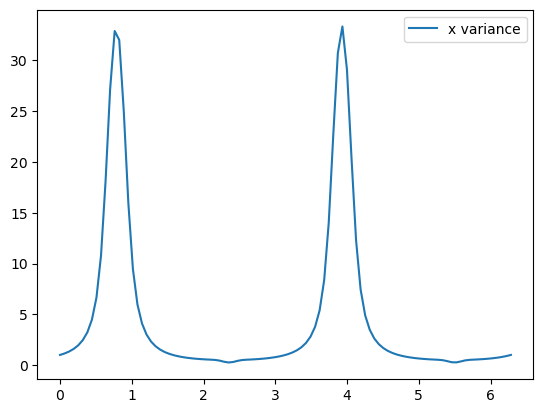

In [126]:
# plot the variance as a function of the rotation angle
var = variance_rotation(target_logPDF)
x = np.linspace(0, 2*math.pi, 100)
plt.plot(x, var[:,0], label='x variance')
plt.legend()
plt.show()

In [127]:
# Calculate the variance as a function of the rotation angle
def variance_rotation_theta(func,theta):
    # rotate the distribution
    var = []
    x = np.linspace(-10, 10, 1000)
    y = np.linspace(-10, 10, 1000)
    x_prime = x*math.cos(theta) - y*math.sin(theta)
    y_prime = x*math.sin(theta) + y*math.cos(theta)
    X, Y = np.meshgrid(x_prime, y_prime)
    Z = func(X, Y)
    Z = np.exp(Z)
    Z /= np.sum(Z)
    # calculate the variance
    x_mean = np.sum(x*Z)
    y_mean = np.sum(y*Z)
    var_x = np.sum((x-x_mean)**2*Z)
    var_y = np.sum((y-y_mean)**2*Z)
    return var_x

In [128]:
# Optimise the variance against the rotation angle
from scipy.optimize import minimize


res = minimize(lambda theta: -variance_rotation_theta(target_logPDF,theta), 0)
print (res.x)
print (-res.fun)

/var/folders/ry/r28_vw1507xg9nf1c8mtsr500000gn/T/ipykernel_44859/2246826133.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_prime = x*math.cos(theta) - y*math.sin(theta)
/var/folders/ry/r28_vw1507xg9nf1c8mtsr500000gn/T/ipykernel_44859/2246826133.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_prime = x*math.sin(theta) + y*math.cos(theta)


[0.78539816]
33.40006673340004


/var/folders/ry/r28_vw1507xg9nf1c8mtsr500000gn/T/ipykernel_44859/1955405859.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_prime = X*math.cos(theta) - Y*math.sin(theta)
/var/folders/ry/r28_vw1507xg9nf1c8mtsr500000gn/T/ipykernel_44859/1955405859.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y_prime = X*math.sin(theta) + Y*math.cos(theta)


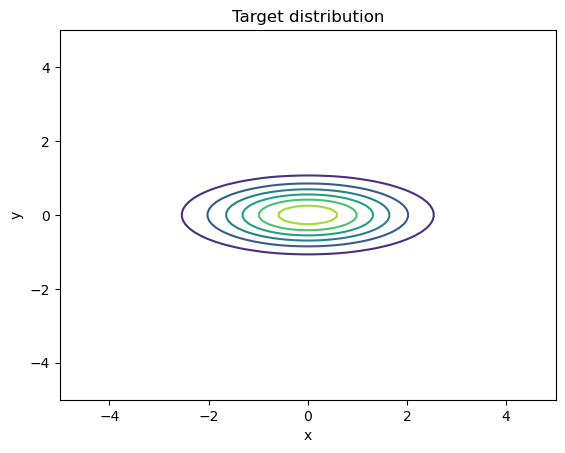

In [129]:
#plot a density plot of the target distribution after rotation
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
theta = res.x
X_prime = X*math.cos(theta) - Y*math.sin(theta)
Y_prime = X*math.sin(theta) + Y*math.cos(theta)
Z = target_logPDF(X_prime, Y_prime)
plt.contour(X, Y, np.exp(Z))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Target distribution')
plt.show()